# Kalibration Time-To-Digital Converter

## Teil 1: Deterministische Signale

----

#### Prof. Christian Münker, 19. Juni 2017

In [9]:
from __future__ import print_function, division
# show plot in notebook instead of separate windows:
%matplotlib inline
from bokeh.plotting import figure# , show # this "show" requires saving to html
from bokeh.io import push_notebook, show, output_notebook # this show is for integrated notebooks
#import bokeh
#print(bokeh.__version__)
output_notebook()

import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import scipy
import scipy.stats

#import ipywidgets as wdg
from ipywidgets import interact
import ipywidgets.widgets as wdg
from IPython.display import display

#plt.style.use('seaborn-whitegrid')
plt.style.use('classic')#('seaborn-dark')
plt.rcParams['figure.figsize'] = (12.0, 5.0) # Plotgröße in Inch
#print(plt.style.available) # alle Matplotlib styles



def gcf(a, b, eps=1e-3):
    """
    Greatest Common FRACTION function also works with fractions:
    gcf(1024, 34)
    >>> 2
    gcf(10, 7.5)
    >>> 2.5
    """
    while abs(b) > eps:
        a, b = b, a % b # a = b, then b = a % b (remainder)
    return a 

# globale Variablen
N = 140      # Anzahl der Verzögerungselemente (Bins)
L = 2**10    # Anzahl der Messungen (= Versuche)

c_0 = 3e8 # Lichtgeschwindigkeit in m/s
d = 0.1 # Entfernung vom Ziel in m
print("t_TOF (d={0}m) = {1:g}s".format(d,2*d/c_0))

Loading BokehJS ...

t_TOF (d=0.1m) = 6.66667e-10s


# Zeitintervalle

Ziel ist es, einen Sampling Clock mit $T = T_0$ und einen Messclock mit $T = T_{M}$ so zu generieren, dass nach $L$ Messungen die Tapped-Delay Lines im Time-to-Digital Converter Zeitintervalle gemessen haben, die gleichverteilt in $[0 \ldots T_0]$ sind. Damit ist eine statistische bzw. deterministische Kalibration möglich.

Beide Clocks sollen aus Kostengründen von einem gemeinsamen Quarzoszillator mit $T = T_{X}$ abgeleitet werden mit $f_{X} \approx 100\,\text{MHz}$. Der Sampling Clock wird daraus mit einem PLL Block und dem Multiplikator $M_0 / D_0$ erzeugt, aus Performancegründen soll möglichst $D_0 = 1$ und $M_0$ möglichst klein sein. Der Messclock wird mit einem MMCM-Block abgeleitet, der mit Hilfe einer Fractional-N PLL auch gebrochenzahlige Multiplikatoren und Divisoren (bezogen auf die Frequenz) $D_{M}$ und $M_{M}$ realisieren kann.

$$
\begin{align}
T_0 &=  \frac {T_{X}}{M_0} \\
T_{M} &= T_{X} \frac {D_{M}}{M_{M}}
\end{align}
$$

Z.Z. wird alle $T_{M} = 11.1 \, \mu$s gemessen, dieser Clock wird von einem separaten Quarzoszillator mit $f_{ext} = 90\,$MHz abgeleitet.

Im Betrieb wird alle $T_{M}$ ein Messvorgang ausgelöst, der nach einem (mehr oder weniger) fixen Offset $T_{o,start}$ zum Zeitpunkt $t_{start,l} = lT_{M} + T_{o,start}$ einen Laserpuls startet. Der vom Ziel im Abstand $d = 0.1 ... 9\,$m reflektierte Puls löst beim Eintreffen zum Zeitpunkt $t_{stop}$ den Stop Puls aus. Dabei ist die Time-of-Flight $T_{TOF} = t_{stop} - t_{start} = 2d\, / \, c_0 = 0.6 ... 60\,\text{ns}$.

Die Time-of-Flight wird gemessen über einen Coarse-Fine Time-to-Digital Converter mit zwei asynchronen Tapped-Delay-Lines (TDL) mit $T_{TOF} = t_{TDL, stop} - t_{TDL, start} + N_{coarse} T_0$. Dabei sind die von den TDLs gemessenen Intervalle $t_{TDL, st*} = kT_0 - t_{st*}$ mit $k$ so, dass $t_{TDL, st*} \in [0 \ldots T_0]$ oder, kürzer formuliert, $t_{TDL, st*} =  \left(k T_0 - t_{st*}\right) \mod T_0$.

Wenn $T_{M}$ **und** $T_0$ von $T_{X}$ abgeleitet werden, hängt $T_{M}$ direkt mit $T_0$ zusammen:

$$
T_{M} = T_{X} \frac {D_{M}}{M_{M}} = \alpha_{M} T_{X} = \alpha_{M} T_{0}M_0 \; \Leftrightarrow \; \frac{T_{M}}{T_0} = \alpha_{M}M_0
$$
Das heißt, das Verhältnis beider Perioden ist konstant und rational, je nach Wahl der Multiplikatoren / Teiler mit einem kleinen Nenner. 

**Dimensionierungsbeispiel:**

- $T_0 = 2$ ns, $f_0 = 500$ MHz. Diese Größe ist fest gewählt.
- $T_{M} = 11.1 \, \mu\text{s}$, $f_{M} = 90$ kHz. Diese Größe kann um ein paar Prozent variiert werden.
- $T_{X} = 10$ ns, $f_{X} = 100$ MHz. Diese Größe kann variert werden, so lange sich $f_0$ mit einem kleinen Multiplikator $M_0$ aus $f_X$ ableiten lässt. Große Faktoren $M_0$ verschlechtern die Jitter / Phase Noise Performance des Sampling Clocks.

Daraus folgt sofort:

$M_0 = T_{X} / T_0 = 5$ und $\alpha_{M} = T_{M} / T_{X}  = \frac{D_{M}}{M_{M}} = 1111.11\ldots$.

Das lässt sich beispielsweise erreichen mit $D_{M} = 10000$ und $M_{M} = 9$. Der Teilerfaktor $D_M$ wird dabei nur teilweise in der PLL realisiert werden und vorwiegend als synchroner Clock Enable. Diese Wahl der Faktoren ist allerdings suboptimal, wenn $t_{TDL}$ möglichst wenig periodisch sein soll.

### Kalibration
Im laufenden Betrieb soll jetzt eine statistische Kalibration der TDLs durchgeführt werden. Für die Start-TDL ist notwendig, dass $t_{TDL, start}$ im Bereich $[0 \ldots T_0]$ gleichverteilt auftritt:

$$
t_{TDL, start} = k T_0 - t_{start} = k T_0 - (lT_{M} + T_{o,start}) =  k T_0 - lT_{M}
$$

wobei der konstante Offset $T_{o,start}$ willkürlich zu Null gesetzt wurde. Bei der $l$-ten Messung ist $t_{TDL, start}$

$$
\frac{t_{TDL, start}}{T_0} = \left( k T_0 - lT_{M} \right) \mod T_0 = \left(- lT_{M} \mod T_0 \right) = \left(l\,\alpha_M M_0 T_0 \mod T_0 \right) = \text{frac}\left(\alpha_M M_0 \right) = \pmb{\textbf{frac} \left(l \frac{D_{M}M_0}{M_{M}}\right)}
$$

Damit $t_{TDL, start}$ bei der $L$-ten Messung 0 wird, muss gelten:

$$
LT_{M} \mod T_0 = {L \,\alpha_M} M_0 \, T_{0} \mod T_{0} \equiv 0 \quad \Rightarrow \quad L \,\alpha_M M_0 = \pmb{L \frac{D_{M}M_0}{M_{M}} = R\; \in \;\mathbb{N}}
$$

$L$ soll eine Zweierpotenz sein, um eine spätere Skalierung der kalibrierten Werte zu erleichtern. $t_{TDL, start}$ sollte nicht vor der $L$-ten Messungen wieder Null werden, da ansonsten weniger als $L$ unterschiedliche Zeitwerte generiert und die Bins weniger gleichmäßig "befüllt" werden.
Das wird erreicht, wenn  $L D_{M} M_0 / M_{M}$ und $R$ teilerfremd sind, also

$$
\text{gcd} \left(L \frac{D_{M}M_0}{M_{M}}, \; R \right) = 1 \text{ ist.}
$$

Damit $t_{TDL, start}$ monoton mit jedem Schritt für $l \in [0; L-1]$ ansteigt, muss $R=1$ sein, also gelten:

$$
\alpha_M M_0 = \frac{D_{M}M_0}{M_{M}} = \pmb{\frac 1 L} \quad \Rightarrow \quad \frac{L D_{M}M_0}{M_{M}} = L \alpha_M M_0 \equiv R = 1
$$

Für ganzzahlige Teiler / Multiplikatoren lässt sich diese Gleichung unter den gegebenen Randbedingungen kaum erfüllen, da $L M_0 = 5 \cdot 1024$ (mindestens) und $\alpha_M$ in der Größenordnung von 1000 liegt, so dass sich bestenfalls (bei geschickter Wahl der Faktoren) $M_M$ unterschiedliche Zeitwerte ergeben. Ein großer Zahlenwert für $M_M$ kann nur mit einer zweistufigen PLL erreicht werden, da ansonsten ausgehend von $f_{X}$ eine sehr hohe Zwischenfrequenz eingestellt werden müsste.

Zum Glück ist der MMCM Block eine Fractional-N PLL, sodass mit dem Integer-Teil $I_M$ des Faktors die ungefähre Frequenz eingestellt werden kann und mit dem Fractional-Teil $F_M$ die gewünschte Periodizität:

$$
\alpha_M = I_M.F_M \quad \text{mit}\quad I_M = \frac{f_{X}}{f_{M}} \quad \text{und}\quad F_M = \frac{p}{L M_0}
$$
 



In [10]:
R = 5
M_M = 1
D_M = 1023 + R/(1024 * 5)
M_0 = 5
D_0 = 1

f_X = 1e8; T_X = 1./f_X # Xtal oscillator 100 MHz
f_0 = f_X * M_0; T_0 = 1./f_0    # Sampling Clock 500 MHz 
f_M = f_X * M_M / D_M; T_M = 1/f_M; a_M = D_M/M_M  #90 kHz / 11.1 us

print("L   = {0:5d}\t| R   = {1:5d}\t| f_X = {2:g} MHz\t\t| T_X = {3:g} ns".format(L, R, f_X/1.e6, T_X * 1.e9))
print("D_0 = {0:5d}\t| M_0 = {1:5d}\t| f_0 = {2:g} MHz\t\t| T_0 = {3:g} ns".format(D_0, M_0, f_0 / 1e6, T_0 * 1e9))
print("D_M = {0:.4f}\t| M_M = {1:g}\t| f_M = {2:.5g} kHz\t| T_M = {3:.5g} us".format(D_M, M_M, f_M/1000, T_M * 1e6))
print("a_M = {0:.4f}\t| I_M = {1:d}\t| F_M = {2:g}".format(a_M, int(np.floor(a_M)), a_M - np.floor(a_M)))


L   =  1024	| R   =     5	| f_X = 100 MHz		| T_X = 10 ns
D_0 =     1	| M_0 =     5	| f_0 = 500 MHz		| T_0 = 2 ns
D_M = 1023.0010	| M_M = 1	| f_M = 97.752 kHz	| T_M = 10.23 us
a_M = 1023.0010	| I_M = 1023	| F_M = 0.000976562


Zeros @ Bin indices =  [[  0]
 [205]]


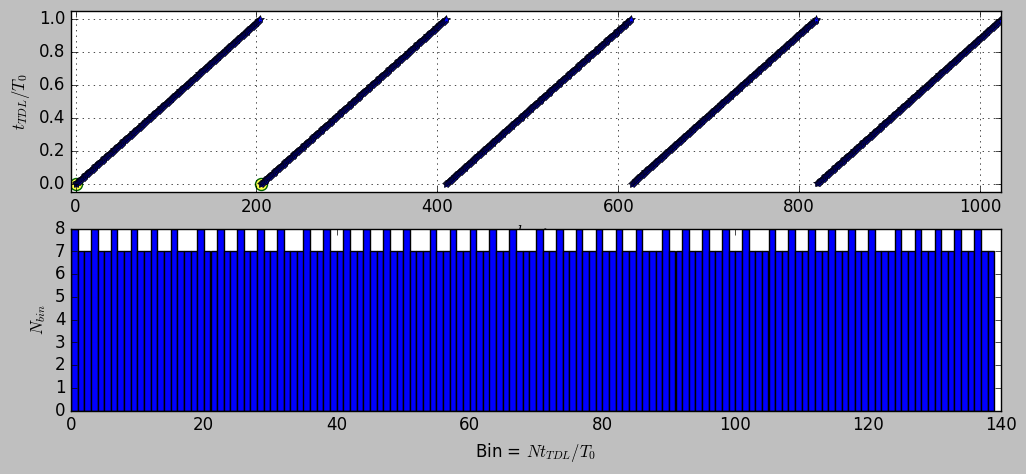

In [11]:
l = np.arange(L) # indices for L measurements
R = 0 # R = 0 ... 1 : randomization factor for bin width 0 -> homogeneous width, 1 -> width = 0 ... 2 * homog. width
bins=np.arange(0, N, 1.) + np.random.rand(N) * R # define bins with randomized width
t_M = l * T_M # measurement time instances
t_M_mod, _ = np.modf(t_M / T_0) # fractional part of measurement instances
#hist, bin_edges = np.histogram(t_M_mod, bins=np.arange(0, 1., 1./N))
hist, bin_edges = np.histogram(t_M_mod * N, bins=bins)
# bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_centers = bin_edges[:-1]

#for t in t_M_mod[390:400]:
#    print("{0:g}".format(t), end=' ')
t_zero = np.argwhere(np.abs(t_M_mod) < 1e-3) 
print("Zeros @ Bin indices = ", t_zero[:20])

fig = plt.figure()
ax1 = fig.add_subplot(211); ax1.grid(True)
ax2 = fig.add_subplot(212)
ax1.scatter(t_zero, np.zeros(len(t_zero)), s = 75, facecolors=(1,1,0.0,0.7),
             edgecolors='darkgreen') # mark zeros
ax1.plot(l, t_M_mod, '*');
ax1.set_xlim([-l[5],max(l)])
ax1.set_ylim([-0.05,1.05])
ax2.bar(bin_centers, hist, width = 1)
ax1.set_xlabel(r"$l ->$")
ax1.set_ylabel(r"$t_{TDL}/T_0$")
ax2.set_ylabel(r"$N_{bin}$");
ax2.set_xlabel(r"Bin = $Nt_{TDL}/T_0$");
#plt.show()

#p = figure(title="interactive example", x_axis_label="l ->", y_axis_label="t_TDL ->")
#p.line(l, t_M_mod)
#t = show(p)
#t = show(p, notebook_handle=True)
#push_notebook(t)

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2017*.

The latest version of this notebook can be found at

[https://github.com/chipmuenk/dsp_fpga/blob/master/notebooks/_div/tdc_calibration_deterrministic.ipynb](https://github.com/chipmuenk/dsp_fpga/blob/master/notebooks/_div/tdc_calibration_deterrministic.ipynb)